In [81]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [82]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [83]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [84]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [85]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)
# Base.prepare(autoload_with=engine)


In [86]:
# View all of the classes that automap found
print('Keys: ')
print(Base.classes.keys())

Keys: 
['measurement', 'station']


In [97]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [116]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Query all data from the "measurement" table
# results = session.query(Measurement).all()

# # Loop through the results and print them
# for result in results:
#     print(f"ID: {result.id}, Date: {result.date}, Precipitation: {result.prcp}, Temperature: {result.tobs}")

ID: 1, Date: 2010-01-01, Precipitation: 0.08, Temperature: 65.0
ID: 2, Date: 2010-01-02, Precipitation: 0.0, Temperature: 63.0
ID: 3, Date: 2010-01-03, Precipitation: 0.0, Temperature: 74.0
ID: 4, Date: 2010-01-04, Precipitation: 0.0, Temperature: 76.0
ID: 5, Date: 2010-01-06, Precipitation: None, Temperature: 73.0
ID: 6, Date: 2010-01-07, Precipitation: 0.06, Temperature: 70.0
ID: 7, Date: 2010-01-08, Precipitation: 0.0, Temperature: 64.0
ID: 8, Date: 2010-01-09, Precipitation: 0.0, Temperature: 68.0
ID: 9, Date: 2010-01-10, Precipitation: 0.0, Temperature: 73.0
ID: 10, Date: 2010-01-11, Precipitation: 0.01, Temperature: 64.0
ID: 11, Date: 2010-01-12, Precipitation: 0.0, Temperature: 61.0
ID: 12, Date: 2010-01-14, Precipitation: 0.0, Temperature: 66.0
ID: 13, Date: 2010-01-15, Precipitation: 0.0, Temperature: 65.0
ID: 14, Date: 2010-01-16, Precipitation: 0.0, Temperature: 68.0
ID: 15, Date: 2010-01-17, Precipitation: 0.0, Temperature: 64.0
ID: 16, Date: 2010-01-18, Precipitation: 0.0,

# Exploratory Precipitation Analysis

In [125]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print("Most Recent Date:", most_recent_date)

Most Recent Date: 2017-08-23


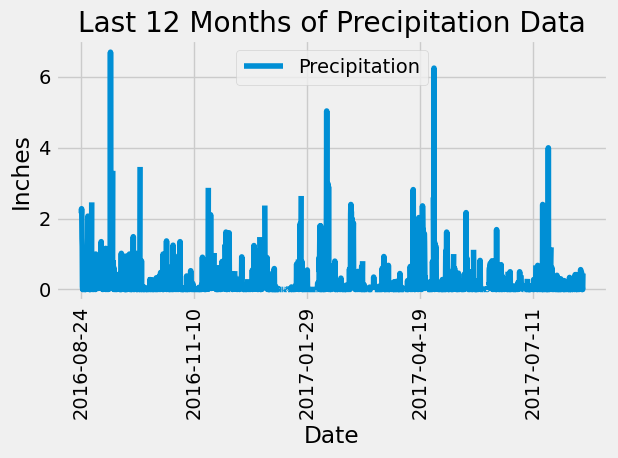

In [147]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Last 12 Months of Precipitation Data")
plt.tight_layout()
plt.show()

In [154]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [160]:
# Design a query to calculate the total number of unique stations in the dataset
total_stations = session.query(func.count(Station.station.distinct())).scalar()
print(total_stations)

9


In [165]:
# Design a query to find the most active stations
active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.station)
    ).group_by(
        Measurement.station
    ).order_by(
        func.count(Measurement.station).desc()
    ).all()

# Print the stations and their counts in descending order
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [172]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()

print(f"Most Active Station: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {round(avg_temp, 2)}")


Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


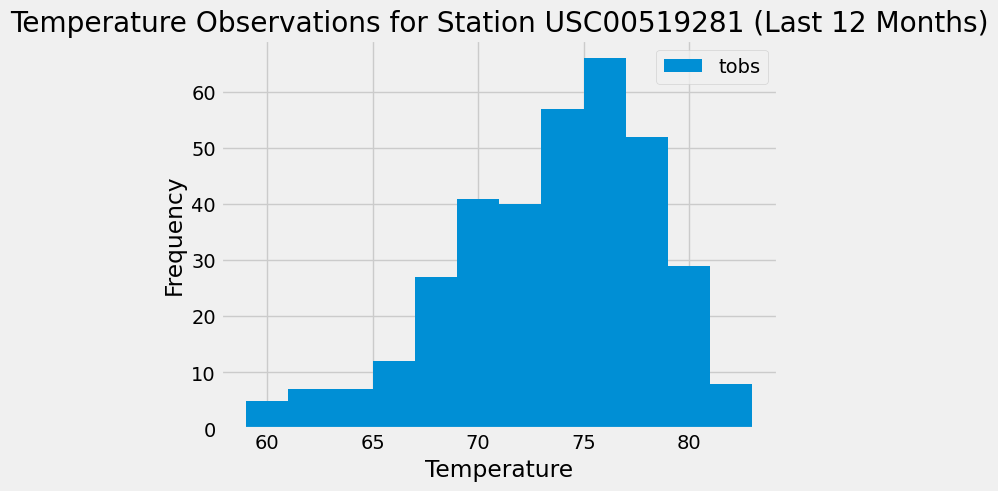

In [175]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Using the most active station ID to query the last 12 months of temperature observation data
temps = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the temperature observations to a list
temps_list = [temp[0] for temp in temps]

# Plotting the results as a histogram
plt.hist(temps_list, bins=12, label='tobs')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.title(f"Temperature Observations for Station {most_active_station} (Last 12 Months)")
plt.legend()
plt.show()

# Close Session

In [176]:
# Close Session
session.close()